### Heart Disease Risk Prediction with Neural Networks

In this notebook, I performed exploratory data analysis on a clinical heart disease dataset, trained a custom neural network module, evaluated its performance, and saved the model along with preprocessing artifacts.

In [1]:
from IPython.display import display

import pickle  
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import seaborn as sns 
from sklearn.metrics import confusion_matrix, matthews_corrcoef, classification_report


import sys
sys.path.append(r"C:\Users\Admin\Desktop\nn_from_scratch\src")

from nn_from_scratch import (
    train_val_test_split,
    TargetEncoder,         
    StandardScaler,      
    MinMaxScaler,      
    NeuralNetwork,      
    train_model,     
    compute_metrics   
)


#### Exploratory Data Analysis (EDA)

In [2]:
df = pd.read_csv(r"C:\Users\Admin\Desktop\nn_from_scratch\data\heart_disease.csv")
print(f"Data Loaded: {df.shape[0]} rows, {df.shape[1]} columns")
display(df.head(3))

Data Loaded: 1048 rows, 13 columns


,Unnamed: 0,age,sex,chest pain type,resting bps,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,2,37,1,2,130,283,0,1,98,0,0.0,1,0


In [3]:
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

rename_map = {
    "chest pain type": "cp",
    "resting bps": "trestbps",
    "cholesterol": "chol",
    "fasting blood sugar": "fbs",
    "resting ecg": "restecg",
    "max heart rate": "thalach",
    "exercise angina": "exang",
    "ST slope": "slope",
}
df.rename(columns=rename_map, inplace=True)


In [4]:
info_df = pd.DataFrame({"Column": df.columns,"Missing Count": df.isnull().sum(),"Dtype": df.dtypes}).reset_index(drop=True)
print("\nDataset Information and Missing Values:")
display(info_df.style.hide(axis="index")) 



Dataset Information and Missing Values:


Column,Missing Count,Dtype
age,0,int64
sex,0,int64
cp,0,int64
trestbps,0,int64
chol,0,int64
fbs,0,int64
restecg,0,int64
thalach,0,int64
exang,0,int64
oldpeak,0,float64


In [5]:
print("\nStatistical Summary of the Dataset:")
display(df.describe().applymap(lambda x: int(x) if x == int(x) else round(x, 1)))


Statistical Summary of the Dataset:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,target
count,1048.0,1048.0,1048.0,1048.0,1048.0,1048.0,1048.0,1048.0,1048.0,1048.0,1048.0,1048.0
mean,53.3,0.7,2.8,132.6,245.2,0.2,0.6,142.9,0.4,0.9,1.5,0.5
std,9.4,0.4,1.1,17.4,57.1,0.4,0.8,24.4,0.5,1.1,0.6,0.5
min,28.0,0.0,1.0,92.0,85.0,0.0,0.0,69.0,0.0,-0.1,0.0,0.0
25%,46.0,0.0,2.0,120.0,208.0,0.0,0.0,125.0,0.0,0.0,1.0,0.0
50%,54.0,1.0,3.0,130.0,239.0,0.0,0.0,144.0,0.0,0.6,2.0,0.0
75%,60.0,1.0,4.0,140.0,275.0,0.0,1.0,162.0,1.0,1.6,2.0,1.0
max,77.0,1.0,4.0,200.0,603.0,1.0,2.0,202.0,1.0,6.2,3.0,1.0


In [6]:
feature_data = { "Variable Name": ["Age", "Sex", "Chest Pain Type (cp)", "Resting Blood Pressure (trestbps)", "Cholesterol (chol)", "Fasting Blood Sugar (fbs)", "Resting ECG Results (restecg)", "Maximum Heart Rate Achieved (thalach)", "Exercise Induced Angina (exang)", "ST Depression Induced by Exercise (oldpeak)", "Slope of the ST Segment (slope)", "Target"], 
                "Variable Code": ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "target"], 
                "Description": ["Age of the person in years", "Gender of the individual (1 = Male, 0 = Female)", "Type of chest pain: 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic", "Resting blood pressure (in mm Hg)", "Serum cholesterol level (in mg/dl)", "Fasting blood sugar > 120 mg/dl (1 = true, 0 = false)", "Resting ECG results: 0 = normal, 1 = ST-T wave abnormality, 2 = left ventricular hypertrophy", "Maximum heart rate achieved", "Exercise-induced angina (1 = yes, 0 = no)", "ST depression induced by exercise relative to rest", "Slope of the peak exercise ST segment: 1 = upsloping, 2 = flat, 3 = downsloping", "Presence of heart disease (1 = disease, 0 = no disease)"], 
                "Domain of Values": ["28 to 77", "0 = Female, 1 = Male", "1 to 4", "92 to 200", "85 to 603", "0 = false, 1 = true", "0 = normal, 1 = ST-T abnormality, 2 = left ventricular hypertrophy", "69 to 202", "0 = no, 1 = yes", "-0.1 to 6.2", "1 to 3", "0 = no disease, 1 = disease"], 
                "Type": ["Continuous", "Nominal Categorical", "Nominal Categorical", "Continuous", "Continuous","Nominal Categorical", "Nominal Categorical", "Continuous", "Nominal Categorical", "Continuous", "Ordinal Categorical", "Nominal Categorical"]}

df_feature_info = pd.DataFrame(feature_data)
df_feature_info.index = [""] * len(df_feature_info)
display(df_feature_info)

,Variable Name,Variable Code,Description,Domain of Values,Type
,Age,age,Age of the person in years,28 to 77,Continuous
,Sex,sex,"Gender of the individual (1 = Male, 0 = Female)","0 = Female, 1 = Male",Nominal Categorical
,Chest Pain Type (cp),cp,"Type of chest pain: 1 = typical angina, 2 = at...",1 to 4,Nominal Categorical
,Resting Blood Pressure (trestbps),trestbps,Resting blood pressure (in mm Hg),92 to 200,Continuous
,Cholesterol (chol),chol,Serum cholesterol level (in mg/dl),85 to 603,Continuous
,Fasting Blood Sugar (fbs),fbs,"Fasting blood sugar > 120 mg/dl (1 = true, 0 =...","0 = false, 1 = true",Nominal Categorical
,Resting ECG Results (restecg),restecg,"Resting ECG results: 0 = normal, 1 = ST-T wave...","0 = normal, 1 = ST-T abnormality, 2 = left ven...",Nominal Categorical
,Maximum Heart Rate Achieved (thalach),thalach,Maximum heart rate achieved,69 to 202,Continuous
,Exercise Induced Angina (exang),exang,"Exercise-induced angina (1 = yes, 0 = no)","0 = no, 1 = yes",Nominal Categorical
,ST Depression Induced by Exercise (oldpeak),oldpeak,ST depression induced by exercise relative to ...,-0.1 to 6.2,Continuous


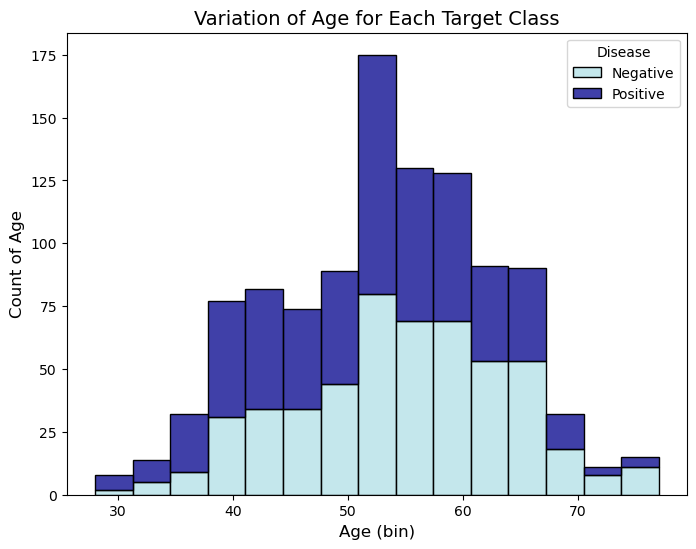

In [60]:
plt.figure(figsize=(8, 6))
sns.histplot(
    data=df,
    x="age",
    hue="target",
    multiple="stack", 
    bins=15,
    palette={0: "darkblue", 1: "powderblue"} 
)
plt.title("Variation of Age for Each Target Class", fontsize=14)
plt.xlabel("Age (bin)", fontsize=12)
plt.ylabel("Count of Age", fontsize=12)
plt.legend(title="Disease", labels=["Negative", "Positive"])
plt.grid(visible=False)  
plt.show()


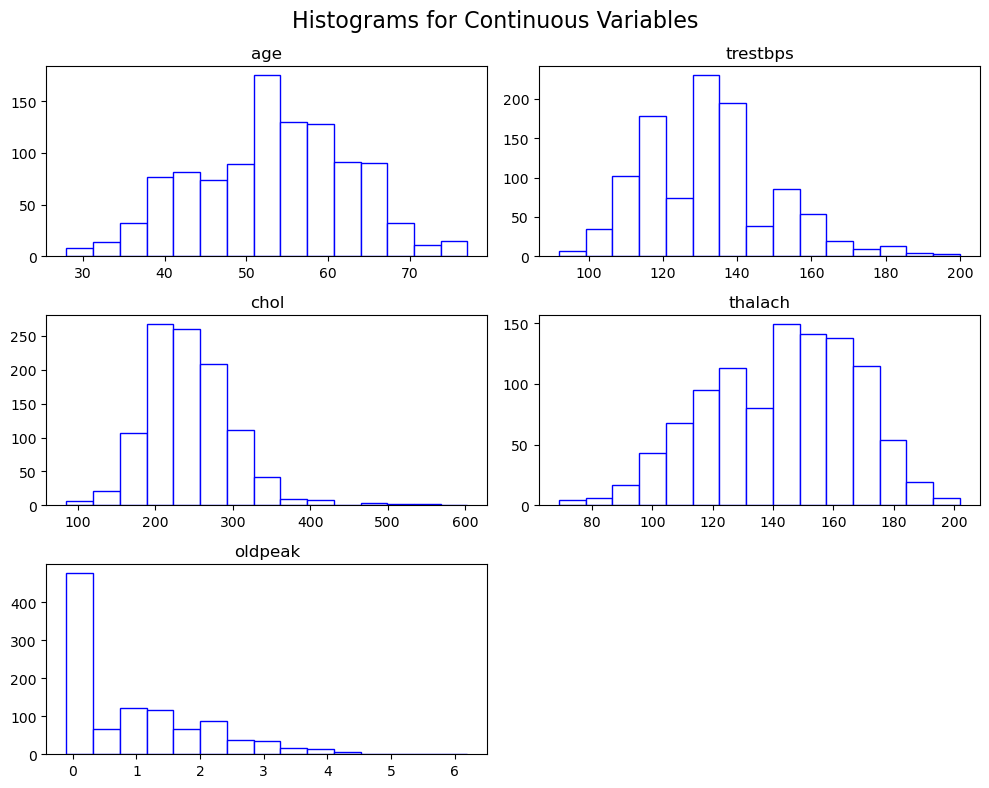

In [23]:
# Histograms for continuous variables 

axes = df[["age", "trestbps", "chol", "thalach", "oldpeak"]].hist(
    figsize=(10, 8), bins=15, color="white", edgecolor="blue"
)

for ax in axes.flatten():
    ax.grid(False) 
    
plt.suptitle("Histograms for Continuous Variables", fontsize=16)
plt.tight_layout()
plt.show()



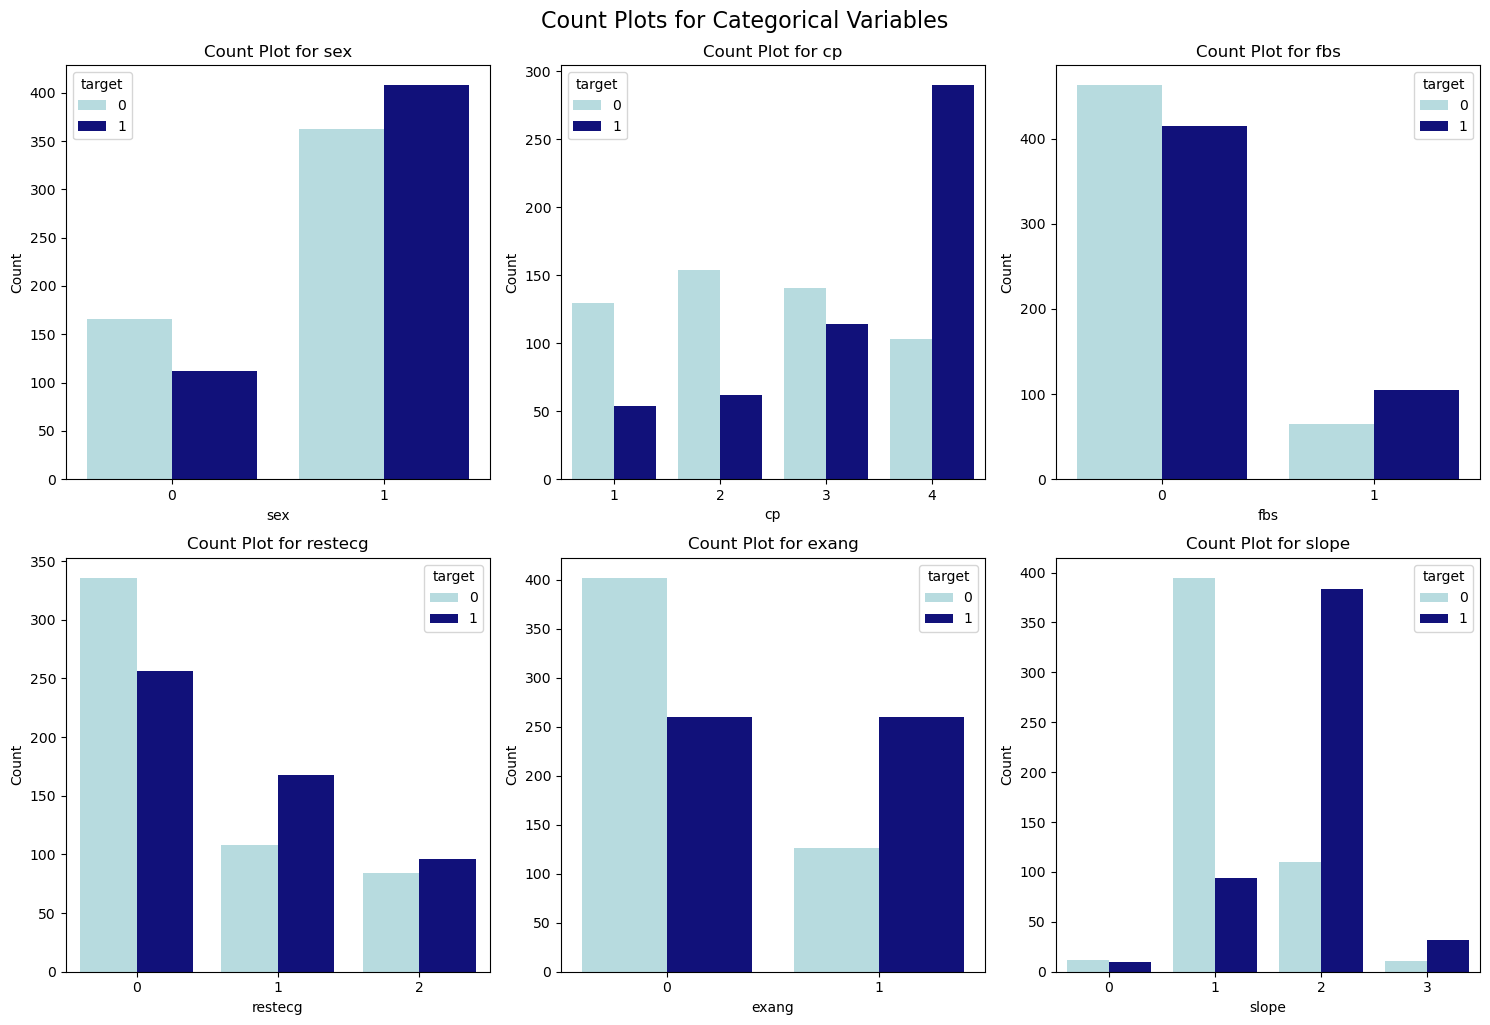

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  

for col, ax in zip(["sex", "cp", "fbs", "restecg", "exang", "slope"], axes.flatten()):
    sns.countplot(data=df, x=col, hue="target", palette=["PowderBlue", "Darkblue"], ax=ax)
    ax.set_title(f"Count Plot for {col}", fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.grid(False)  

plt.tight_layout()
plt.suptitle("Count Plots for Categorical Variables", fontsize=16, y=1.02)
plt.show()

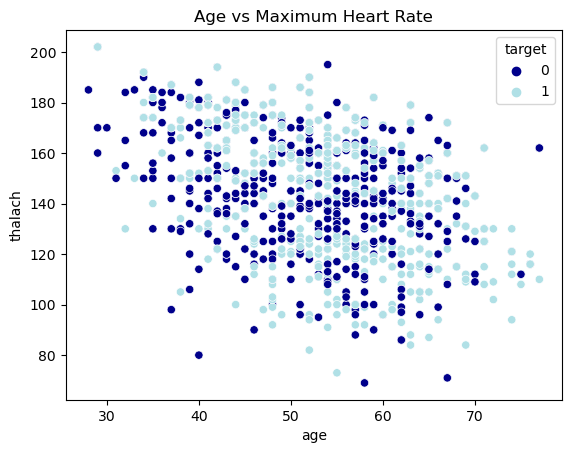

In [57]:
sns.scatterplot(data=df, x="age", y="thalach", hue="target", palette=["darkblue", "powderblue"])
plt.title("Age vs Maximum Heart Rate")
plt.show()


Distribution of Target Classes:


,Count
Class,
0,528
1,520


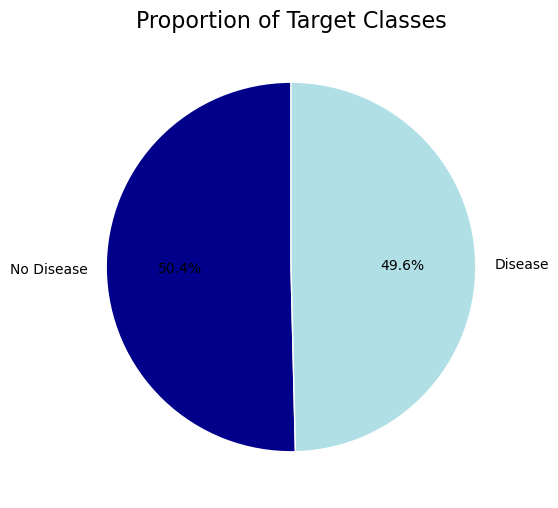

In [59]:
target_counts = df["target"].value_counts()
print("Distribution of Target Classes:")
display(target_counts.to_frame("Count").rename_axis("Class"))

plt.figure(figsize=(8, 6))
plt.pie(target_counts, labels=["No Disease", "Disease"], autopct='%1.1f%%', startangle=90,
        colors=["darkblue", "powderblue"], wedgeprops={'edgecolor': "white"})
plt.title("Proportion of Target Classes", fontsize=16)
plt.show()


#### Data Preprocessing

In [12]:
train_df, val_df, test_df = train_val_test_split(
    df, train_ratio=0.70, val_ratio=0.15, seed=42
)
print("Train size:", len(train_df), "Val size:", len(val_df), "Test size:", len(test_df))


Train size: 733 Val size: 157 Test size: 158


In [13]:
target_col = "target" 
cat_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope"] # categorical 
num_cols = ["age", "trestbps", "chol", "thalach"] # continuous 
float_cols = ["oldpeak"] # float

In [14]:
encoder = TargetEncoder()
train_enc = encoder.fit_transform(train_df, cat_cols, target_col)
val_enc   = encoder.transform(val_df, cat_cols)
test_enc  = encoder.transform(test_df, cat_cols)

std_scaler = StandardScaler()
train_std = std_scaler.fit_transform(train_enc, num_cols)
val_std   = std_scaler.transform(val_enc, num_cols)
test_std  = std_scaler.transform(test_enc, num_cols)

mm_scaler = MinMaxScaler()
train_scaled = mm_scaler.fit_transform(train_std, float_cols)
val_scaled   = mm_scaler.transform(val_std, float_cols)
test_scaled  = mm_scaler.transform(test_std, float_cols)

In [15]:
X_train = train_scaled.drop(columns=[target_col], errors="ignore").values
y_train = train_df[target_col].values.reshape(-1, 1)

X_val = val_scaled.drop(columns=[target_col], errors="ignore").values
y_val = val_df[target_col].values.reshape(-1, 1)

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "y_val shape:", y_val.shape)


X_train shape: (733, 11) y_train shape: (733, 1)
X_val shape: (157, 11) y_val shape: (157, 1)


The model was initially trained and evaluated on the training and validation sets. After confirming the model's performance, the training and validation sets were combined to retrain the model. The final evaluation was done on test data to check how well the model performs on new data.

In [16]:
model = NeuralNetwork(input_dim=X_train.shape[1])

train_model(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=20,
    batch_size=64,
    lr=1e-3
)


Epoch [1/20] Train Loss: 0.6899 | Val Loss: 0.6900 | Acc: 0.567 | Prec: 0.543 | Rec: 0.514 | MCC: 0.129
Epoch [2/20] Train Loss: 0.6831 | Val Loss: 0.6861 | Acc: 0.573 | Prec: 0.542 | Rec: 0.608 | MCC: 0.150
Epoch [3/20] Train Loss: 0.6734 | Val Loss: 0.6819 | Acc: 0.554 | Prec: 0.522 | Rec: 0.635 | MCC: 0.118
Epoch [4/20] Train Loss: 0.6575 | Val Loss: 0.6761 | Acc: 0.580 | Prec: 0.549 | Rec: 0.608 | MCC: 0.162
Epoch [5/20] Train Loss: 0.6450 | Val Loss: 0.6728 | Acc: 0.567 | Prec: 0.538 | Rec: 0.568 | MCC: 0.134
Epoch [6/20] Train Loss: 0.6258 | Val Loss: 0.6649 | Acc: 0.567 | Prec: 0.537 | Rec: 0.581 | MCC: 0.135
Epoch [7/20] Train Loss: 0.6094 | Val Loss: 0.6438 | Acc: 0.599 | Prec: 0.575 | Rec: 0.568 | MCC: 0.194
Epoch [8/20] Train Loss: 0.5935 | Val Loss: 0.6160 | Acc: 0.637 | Prec: 0.613 | Rec: 0.622 | MCC: 0.272
Epoch [9/20] Train Loss: 0.5660 | Val Loss: 0.5786 | Acc: 0.694 | Prec: 0.703 | Rec: 0.608 | MCC: 0.385
Epoch [10/20] Train Loss: 0.5400 | Val Loss: 0.5607 | Acc: 0.713

In [17]:
merged_train_val = pd.concat([train_df, val_df], ignore_index=True)

final_encoder = TargetEncoder()
merged_enc = final_encoder.fit_transform(merged_train_val, cat_cols, target_col)
test_enc2 = final_encoder.transform(test_df, cat_cols)

final_std_scaler = StandardScaler()
merged_std = final_std_scaler.fit_transform(merged_enc, num_cols)
test_std2 = final_std_scaler.transform(test_enc2, num_cols)

final_mm_scaler = MinMaxScaler()
merged_scaled = final_mm_scaler.fit_transform(merged_std, float_cols)
final_test_scaled = final_mm_scaler.transform(test_std2, float_cols)


In [18]:
X_train_val = merged_scaled.drop(columns=[target_col], errors="ignore").values
y_train_val = merged_scaled[target_col].values.reshape(-1, 1)

X_test = final_test_scaled.drop(columns=[target_col], errors="ignore").values
y_test = final_test_scaled[target_col].values.reshape(-1, 1)

print("X_train_val shape:", X_train_val.shape, "y_train_val shape:", y_train_val.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)


X_train_val shape: (890, 11) y_train_val shape: (890, 1)
X_test shape: (158, 11) y_test shape: (158, 1)


#### Model Training

In [19]:
model = NeuralNetwork(input_dim=X_train_val.shape[1])
train_model(
    model=model,
    X_train=X_train_val,
    y_train=y_train_val,
    X_val=X_test,   
    y_val=y_test,
    epochs=20,
    batch_size=64,
    lr=1e-3
)

Epoch [1/20] Train Loss: 0.6903 | Val Loss: 0.6886 | Acc: 0.506 | Prec: 0.489 | Rec: 0.880 | MCC: 0.069
Epoch [2/20] Train Loss: 0.6822 | Val Loss: 0.6827 | Acc: 0.551 | Prec: 0.516 | Rec: 0.867 | MCC: 0.164
Epoch [3/20] Train Loss: 0.6704 | Val Loss: 0.6720 | Acc: 0.570 | Prec: 0.532 | Rec: 0.773 | MCC: 0.172
Epoch [4/20] Train Loss: 0.6523 | Val Loss: 0.6552 | Acc: 0.582 | Prec: 0.545 | Rec: 0.733 | MCC: 0.186
Epoch [5/20] Train Loss: 0.6266 | Val Loss: 0.6256 | Acc: 0.671 | Prec: 0.639 | Rec: 0.707 | MCC: 0.345
Epoch [6/20] Train Loss: 0.5953 | Val Loss: 0.5904 | Acc: 0.677 | Prec: 0.640 | Rec: 0.733 | MCC: 0.361
Epoch [7/20] Train Loss: 0.5557 | Val Loss: 0.5433 | Acc: 0.747 | Prec: 0.733 | Rec: 0.733 | MCC: 0.492
Epoch [8/20] Train Loss: 0.5287 | Val Loss: 0.5110 | Acc: 0.778 | Prec: 0.786 | Rec: 0.733 | MCC: 0.556
Epoch [9/20] Train Loss: 0.5103 | Val Loss: 0.4958 | Acc: 0.797 | Prec: 0.779 | Rec: 0.800 | MCC: 0.595
Epoch [10/20] Train Loss: 0.4979 | Val Loss: 0.4849 | Acc: 0.804

#### Model Evaluation 

In [20]:
pred_test = model.forward(X_test)
binary_preds = (pred_test >= 0.5).astype(int)

print(classification_report(y_test, binary_preds))


              precision    recall  f1-score   support

           0       0.82      0.75      0.78        83
           1       0.74      0.81      0.78        75

    accuracy                           0.78       158
   macro avg       0.78      0.78      0.78       158
weighted avg       0.78      0.78      0.78       158



For evaluation recall will be considered, it is particularly important because the dataset deals with heart disease prediction, where false negatives (failing to identify patients with heart disease) can have severe consequences. The recall for the positive class (patients with heart disease) is 0.81, meaning the model correctly identifies 81% of actual cases, reducing the likelihood of missing high-risk individuals. The confusion matrix shows that while the model correctly classifies 61 cases of heart disease, it still misclassifies 14 cases as negative. The Matthews Correlation Coefficient (MCC) of 0.56 indicates a moderate correlation between predictions and actual labels, reflecting that the model performs reasonably well.

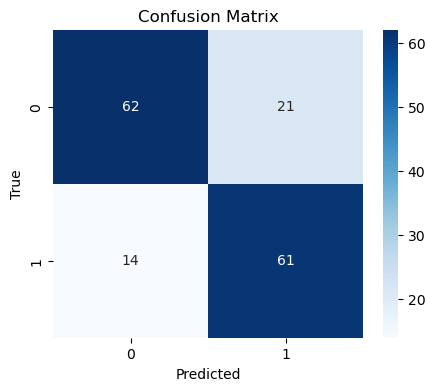

Matthews Correlation Coefficient (MCC): 0.5600


In [21]:
cm = confusion_matrix(y_test, binary_preds)
mcc = matthews_corrcoef(y_test, binary_preds)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")


#### Saving the model and Preprocessing

In [22]:
with open(r"C:\Users\Admin\Desktop\nn_from_scratch\model\model.pkl", "wb") as f:
    pickle.dump(model, f)

with open(r"C:\Users\Admin\Desktop\nn_from_scratch\model\preprocessing.pkl", "wb") as f:
    pickle.dump({
        "encoder": final_encoder,
        "std_scaler": final_std_scaler,
        "mm_scaler": final_mm_scaler,
        "cat_cols": cat_cols,
        "num_cols": num_cols,
        "float_cols": float_cols
    }, f)